In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def create_metrics_comparison(results_path="../results"):
    """
    Create a comparison table for different models using all evaluation metrics.
    """
    
    # Metric configuration
    metric_config = {
        'WAPE': {'format': '{:.1f}%'},
        'MAPE': {'format': '{:.1f}%'},
        'R²': {'format': '{:.3f}'},
        'MSE': {'format': '{:.1f}'},
        'RMSE': {'format': '{:.1f}'},
        'MAE': {'format': '{:.0f}'},
    }
    
    # Load results
    dfs = []
    for file_path in glob(os.path.join(results_path, "*average_results.csv")):
        df = pd.read_csv(file_path, index_col=0)
        df['Source_File'] = os.path.basename(file_path)
        dfs.append(df)

    all_models_results = pd.concat(dfs, ignore_index=True)

    # Mapping dictionaries with defined order y agregando Lasso y Ridge
    model_names = {
        'LinearRegression': 'LR',
        'KNeighborsRegressor': 'KNN',
        'RandomForestRegressor': 'RF',
        'XGBRegressor': 'XGB',
        'CatBoostRegressor': 'CAT',
        'LR Lasso': 'Lasso',   
        'LR Ridge': 'Ridge'    
    }
    
    strategy_names = {
        'within_domain': 'Within Domain',
        'cross_domain': 'Cross Domain',
        'all_domain': 'All Domain'
    }

    target_names = {
        'Non-residential EUI (kWh/m2/year)': 'Non-residential',
        'Residential EUI (kWh/m2/year)': 'Residential'
    }

    # Apply mappings
    all_models_results['Strategy'] = all_models_results['Strategy'].map(strategy_names)
    all_models_results['Model'] = all_models_results['Model'].map(model_names)
    all_models_results['Target'] = all_models_results['Target'].map(target_names)

    # Set categorical order for models, incluyendo Lasso y Ridge
    model_order = ['LR', 'Lasso', 'Ridge', 'KNN', 'RF', 'XGB', 'CAT']
    all_models_results['Model'] = pd.Categorical(
        all_models_results['Model'],
        categories=model_order,
        ordered=True
    )

    # Create full detailed table with ordered metrics
    metrics = ['MSE', 'MAE', 'WAPE', 'RMSE', 'R²', 'MAPE']
    
    full_table = pd.pivot_table(
        all_models_results,
        index=['Model', 'Target'],
        columns=['Strategy'],
        values=metrics,
        aggfunc='mean'
    ).sort_index(level=0)

    # Format the values according to metric configuration
    formatted_table = full_table.copy()
    for metric in metrics:
        for strategy in strategy_names.values():
            col = (metric, strategy)
            formatted_table[col] = formatted_table[col].apply(
                lambda x: metric_config[metric]['format'].format(x)
            )
    
    return formatted_table

In [3]:
def create_model_comparison(comparison_table, metric, save_path=None ):
    """
    Create a comparison plot for different models using a specified metric.
    
    Parameters:
    -----------
    comparison_table : pd.DataFrame
        The formatted table from create_metrics_comparison function
    metric : str
        The metric to compare. Options: 'MAPE', 'R²', 'MSE', 'RMSE', 'MAE', 'WAPE'
    save_plot : bool
        Whether to save the plot to file
    save_path : str
        The path where the plot should be saved
    
    Returns:
    --------
    matplotlib.figure.Figure
        The generated plot
    """
    
    # Metric configuration with average labels
    metric_config = {
        'R²': {'format': '%.3f', 'label': 'Avg. R²', 'limits': (-1, 1)},
        'MSE': {'format': '%.0f', 'label': 'Avg. MSE', 'limits': (0, None)},
        'RMSE': {'format': '%.1f', 'label': 'Avg. RMSE', 'limits': (0, None)},
        'MAE': {'format': '%.1f', 'label': 'Avg. MAE', 'limits': (0, None)},
        'WAPE': {'format': '%.1f%%', 'label': 'Avg. WAPE (%)', 'limits': (0, 100)},
        'MAPE': {'format': '%.0f%%', 'label': 'Avg. MAPE (%)', 'limits': (0, 100)}
    }
    
    # Prepare data for plotting
    plot_data = comparison_table[metric].reset_index()
    plot_data = plot_data.melt(id_vars=['Model', 'Target'], 
                              var_name='Strategy', 
                              value_name=metric)
    
    # Convert string percentages to float for plotting
    if metric in ['MAPE', 'WAPE']:
        plot_data[metric] = plot_data[metric].str.rstrip('%').astype(float)
    else:
        plot_data[metric] = plot_data[metric].astype(float)

    # Color palette
    custom_palette = {
        'Non-residential': '#8ab2d5', 
        'Residential': '#98d095'
    }

    # Create plot
    fig, axes = plt.subplots(1, 3, figsize=(22, 8))
    strategies = ['Within Domain', 'Cross Domain', 'All Domain']

    # Calculate dynamic limits
    min_val = plot_data[metric].min()
    max_val = plot_data[metric].max()
    padding = (max_val - min_val) * 0.1
    
    # Set y-axis limits based on metric configuration
    base_min, base_max = metric_config[metric]['limits']
    y_min = base_min if base_min is not None else max(min_val - padding, 0)
    y_max = base_max if base_max is not None else max_val + padding

    for ax, strategy in zip(axes, strategies):
        strategy_data = plot_data[plot_data['Strategy'] == strategy]
        
        # Create bar plot
        bars = sns.barplot(
            data=strategy_data,
            x='Model',
            y=metric,
            hue='Target',
            palette=custom_palette,
            ax=ax
        )
        
        # Add value labels
        for container in bars.containers:
            bars.bar_label(container, 
                          fmt=metric_config[metric]['format'], 
                          padding=5, 
                          fontsize=14)
        
        # Customize appearance
        ax.set_title(f'{strategy}',
                    fontsize=16,
                    pad=20,
                    fontweight='bold')
        ax.set_ylabel(metric_config[metric]['label'], fontsize=14)
        ax.set_ylim(y_min, y_max)
        
        # Remove x-axis label
        ax.set_xlabel('')
        
        # Add baseline
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.3)
        
        # Adjust x-axis labels
        plt.setp(ax.get_xticklabels(), ha='right', fontsize=14)
        
        # Position legend with adjusted position and style
        if strategy == 'Cross Domain':
            legend = ax.legend(bbox_to_anchor=(0.5, -0.05),
                             loc='upper center',
                             ncol=2,
                             fontsize=16)
            # Remove bold from legend labels
            for text in legend.get_texts():
                text.set_fontweight('normal')
        else:
            ax.legend([],[], frameon=False)

    plt.tight_layout()

    # Save plot if requested
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig


In [4]:
comparison_table = create_metrics_comparison(results_path="../results")
comparison_table

MAE                                  MAPE  \
Strategy              All Domain Cross Domain Within Domain All Domain   
Model Target                                                             
LR    Non-residential         40           55            34      21.0%   
      Residential             24           32            27      22.2%   
Lasso Non-residential         39           52            23      20.5%   
      Residential             22           25            21      21.1%   
Ridge Non-residential         40           55            25      21.0%   
      Residential             23           29            21      21.8%   
KNN   Non-residential         18           43            21       9.2%   
      Residential             18           30            20      13.8%   
RF    Non-residential         19           25            16       9.2%   
      Residential             16           26            16      12.3%   
XGB   Non-residential         20           29            16       9.3%   
      Residential             17           27            18      12.5%   
CAT   Non-residential         20           35            17      10.2%   
      Residential             18           25            17      14.0%   

                                                        MSE               \
Strategy              Cross Domain Within Domain All Domain Cross Domain   
Model Target                                                               
LR    Non-residential        32.2%         19.1%     3397.1       5470.0   
      Residential            35.1%         23.2%     1053.1       1567.9   
Lasso Non-residential        29.6%         13.3%     3299.6       4928.0   
      Residential            26.2%         18.5%      923.5       1048.2   
Ridge Non-residential        31.9%         14.6%     3396.4       5381.1   
      Residential            32.0%         18.5%     1026.7       1401.3   
KNN   Non-residential        23.2%         10.8%     1114.7       4212.2   
      Residential            25.8%         15.3%      905.3       1543.6   
RF    Non-residential        12.5%          8.1%     1230.3       2112.4   
      Residential            22.2%         12.5%      692.9       1345.2   
XGB   Non-residential        14.0%          7.8%     1850.2       2673.5   
      Residential            21.6%         13.1%      914.0       1564.0   
CAT   Non-residential        17.8%          8.1%     1447.2       3042.3   
      Residential            20.0%         12.8%      728.2       1351.5   

                                          RMSE                             \
Strategy              Within Domain All Domain Cross Domain Within Domain   
Model Target                                                                
LR    Non-residential        3561.5       47.5         65.0          46.7   
      Residential            2039.3       30.2         39.3          36.1   
Lasso Non-residential        1660.5       47.0         61.1          33.9   
      Residential            1315.9       27.5         30.7          29.2   
Ridge Non-residential        2126.5       47.5         64.3          36.9   
      Residential            1406.4       29.6         36.9          30.0   
KNN   Non-residential        1692.4       27.4         57.8          31.7   
      Residential             944.4       24.8         36.2          25.9   
RF    Non-residential        1169.9       28.1         37.7          27.5   
      Residential             747.7       22.2         32.3          23.2   
XGB   Non-residential         988.6       32.6         42.3          24.9   
      Residential             880.1       24.1         33.7          25.6   
CAT   Non-residential        1142.3       31.2         47.2          27.0   
      Residential             756.5       23.3         30.7          23.6   

                              R²                                  WAPE  \
Strategy              All Domain Cross Domain Within Domain All Domain   
Model Target       

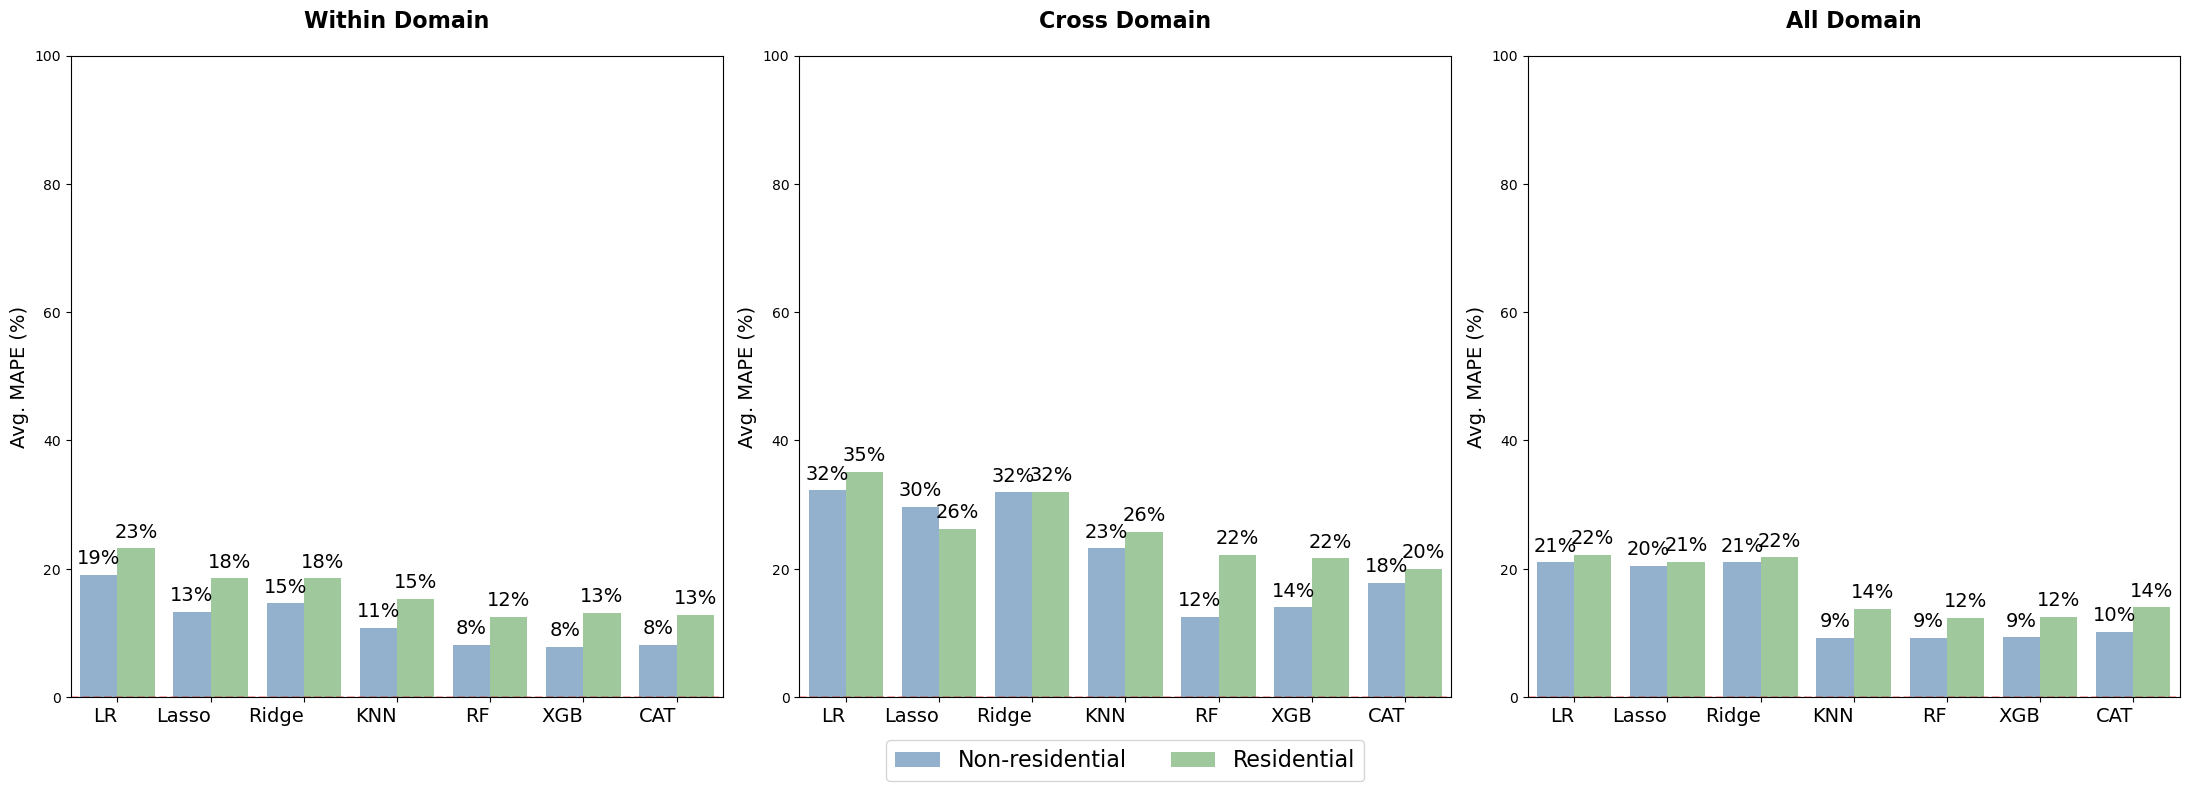

In [5]:
fig = create_model_comparison(comparison_table, metric='MAPE', save_path='../figures/model_plots/00_model_comparison_mape.png')
plt.show()


In [6]:
comparison_table.to_csv("../results/comparison_average_results.csv")

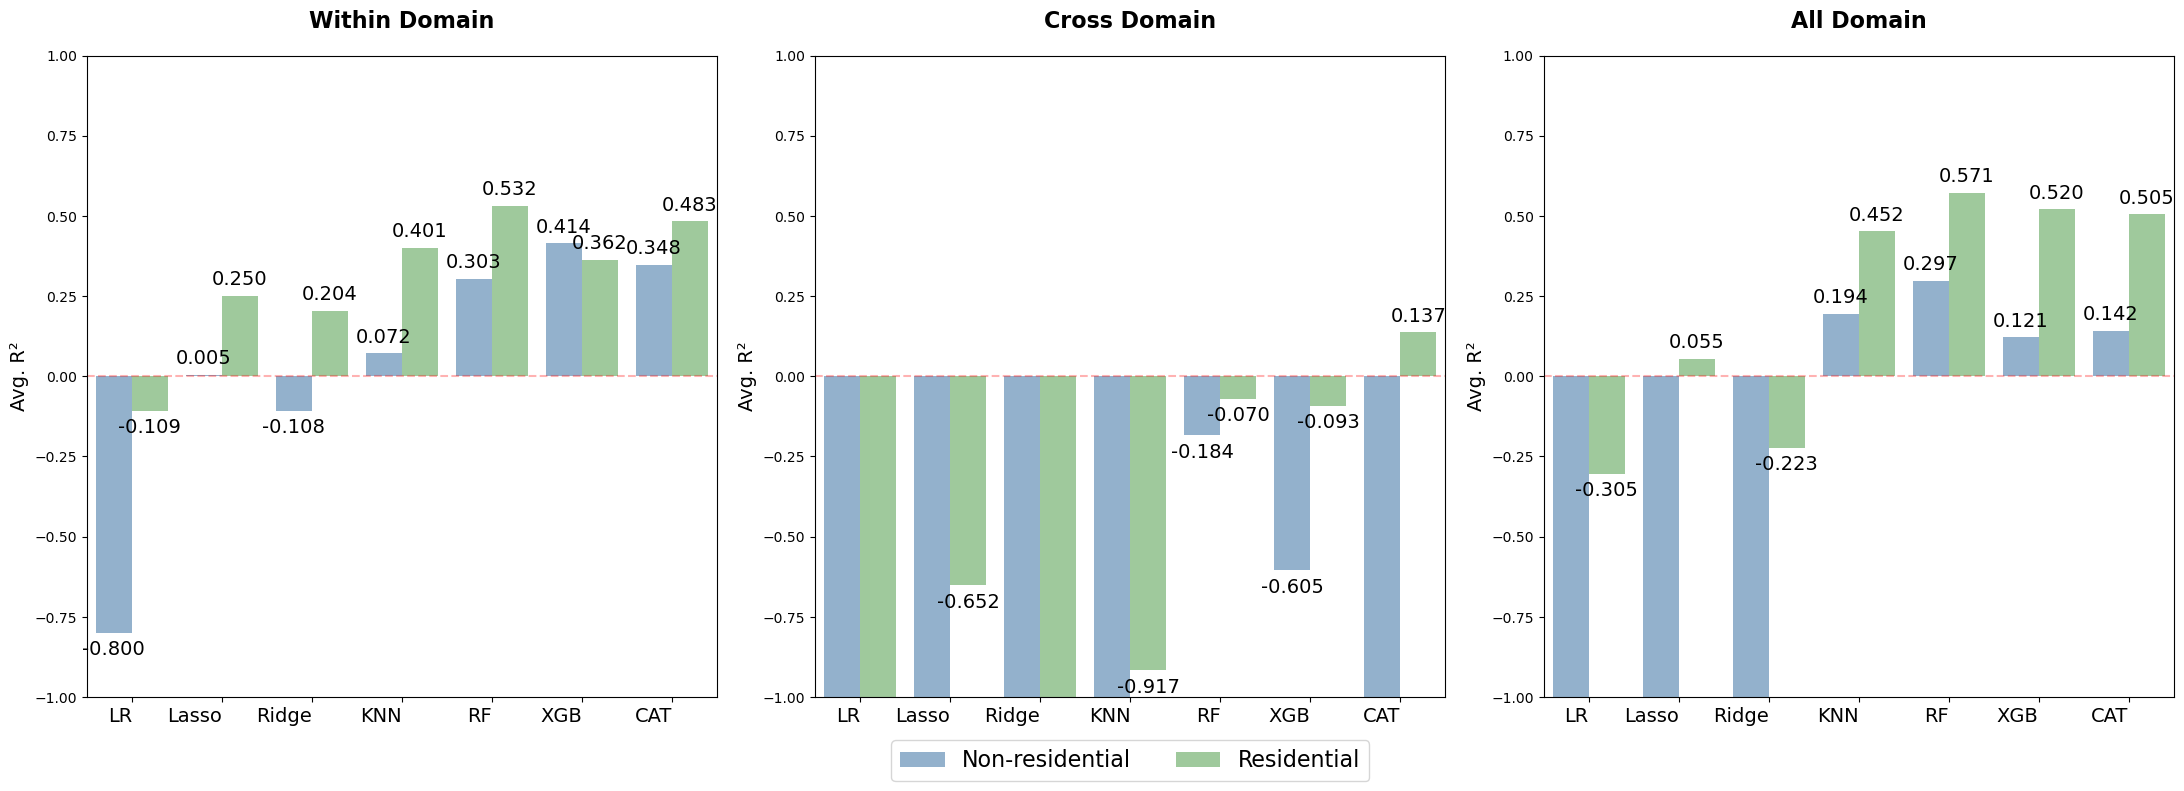

In [7]:
fig = create_model_comparison(comparison_table, metric='R²', save_path='../figures/model_plots/00_model_comparison_r2.png')
plt.show()